# Accessing GEDI L4A Dataset with NASA OPeNDAP in the Cloud

## Overview
The **Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)**{cite}`dubayah2022` dataset provides predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated GEDI footprint. GEDI L4A dataset is available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L4A data files are natively in HDF5 format.

This tutorial will demonstrate how to directly access and subset the GEDI L4A dataset using [NASA OPeNDAP Hyrax](https://opendap.earthdata.nasa.gov/). Hyrax allows direct access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data files. We will compute the distribution of carbon stocks or AGBD for a protected area using the GEDI L4A dataset.

```{admonition} Learning Objectives
- Use [NASA OPeNDAP Hyrax](https://opendap.earthdata.nasa.gov/) to retrieve the GEDI L4A dataset. Hyrax allows direct access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.
- Compute distributions of AGBD across various plant functional types (PFTs) in a study area.
```

## Requirements
Additional prerequisites are provided [here](https://ornldaac.github.io/gedi_tutorials/prerequisites). 

In [1]:
import earthaccess
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
from matplotlib import pyplot as plt
from shapely.ops import orient
from requests.adapters import HTTPAdapter, Retry
from pqdm.threads import pqdm
import seaborn as sns
sns.set(style='whitegrid')

Access to NASA OPeNDAP requires NASA Earthdata authentication. We recommend authenticating your Earthdata Login (EDL) information using the earthaccess python library as follows:

In [2]:
# works if the EDL login already been persisted to a netrc
try:
    auth = earthaccess.login(strategy="netrc")
except FileNotFoundError:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## 1. Search GEDI L4A granules
First, we will search for granules that overlay our area of interest. We will then access the location and science variables for the GEDI shots using OPeNDAP.

For this tutorial, we will use the boundary of [Annapurna Conservation Area (ACA)](https://en.wikipedia.org/wiki/Annapurna_Conservation_Area), the largest protected area of Nepal, to search for the overlapping GEDI L4A granules. The boundary polygon is available as a GeoJSON file at `polygons/aca.json`. Let's plot the boundary polygon of the ACA over a basemap.

In [3]:
# read and plot ACA GeoJSON file
aca = gpd.read_file("polygons/aca.json")
aca.explore(color="red", alpha=0.3)

We will now search for all the GEDI L4A granules overlapping the ACA boundary polygon using the [Earthaccess](https://nsidc.github.io/earthaccess/) Python library. We will also limit the period of our search to the year 2020 (Jan 1 to Dec 31, 2020). The earthaccess's search_data allows searching dataset granules using NASA's [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). It requires the dataset digital object identifier (DOI), time, and the polygon coordinates as tuples.

In [4]:
# GEDI L4A DOI 
DOI = '10.3334/ORNLDAAC/2056'

# time-bound for the year 2020
DATE1 = "2020-01-01" # specify your start date
DATE2 = "2020-12-31"  # specify your end date

# bounding lon, lat as a list of tuples
aca.geometry = aca.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .005 degrees
xy = aca.geometry.simplify(0.005).get_coordinates()
coord_list = [(x,y) for x,y in zip(xy.x , xy.y)]

granules = earthaccess.search_data(
    doi=DOI,
    polygon=coord_list,
    temporal=(DATE1, DATE2)
)
total_granules = len(granules)
print(f"Total granules found: {total_granules}")

Total granules found: 60


Now, the GEDI L4A granule information, including data URLs, is stored in `granule_arr`, from which we can create OPeNDAP URLs. We will use NetCDF-4 encoding in the HTTP requests as an NC4 file representation. Let's print the first three granules from the list.

## 2. Access the variables of interest for the subset area via OPeNDAP
Access to NASA OPeNDAP requires NASA Earthdata authentication. Please set up a new account if you do not already have a NASA Earthdata account. We will use `earthaccess` module to set up the authentication and return a session instance with an authorized bearer token.

In [5]:
# Setting up the python session 
session = earthaccess.get_requests_https_session()

OPeNDAP allows access to the dataset of interest, so you can only download the variables you are interested in and, by doing so, save the download bandwidth. We are interested in the following selected science variables for all the eight GEDI beams for this tutorial.

In [6]:
# variables of interests
variables = ['agbd', 'l4_quality_flag', 'land_cover_data/pft_class']

# beams of interest
BEAMS = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

We will save the data retrieved from OPeNDAP into a pandas dataframe. Let's first define the headers for the dataframe.

In [7]:
# setting header variables
headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
headers.extend(variables)

Now, we will retrieve the dataset from the OPeNDAP Hyrax server.  We will use the following approach to access the dataset. First, we will access the geographic variables (`lat_lowestmode`, `lon_lowestmode`) of all the GEDI shots within the beam to identify the shots overlapping the area of interest. We will then retrieve the science variables of interest (`agbd`, `agbd_t`, etc.) for the area of interest.

The following step will take time to run. The figure below will update to indicate the files being downloaded.

In [8]:
# setting up maximum retries to get around Hyrax 500 error
retries = Retry(total=3, backoff_factor=0.1, status_forcelist=[ 500, 502, 503, 504 ])
session.mount('https://', HTTPAdapter(max_retries=retries))

def gedi_l4a_subset(gr):
    """retrieves gedi shots within the polygon """
    g_name = gr._filter_related_links('USE SERVICE API')[0]
    dfs = []
    # loop over all beams
    for beam in BEAMS:
        # 1. Retrieving lat, lon coordinates for the file
        hyrax_url = f"{g_name}.dap.nc4?dap4.ce=/{beam}/lon_lowestmode;/{beam}/lat_lowestmode"
        r = session.get(hyrax_url)
        if r.status_code != 400:
            ds = nc.Dataset('hyrax', memory=r.content)
            # creating pandas dataframe
            df = pd.DataFrame({'lat_lowestmode': ds[beam]['lat_lowestmode'][:],
                               'lon_lowestmode': ds[beam]['lon_lowestmode'][:]})
            ds.close()

            # 2. Subsetting by bounds of the area of interest
            # converting to geopandas dataframe
            gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",
                                   geometry=gpd.points_from_xy(df.lon_lowestmode,
                                                               df.lat_lowestmode))
            gdf_aca = gpd.sjoin(gdf, aca[['geometry']], predicate='within')
            # gdf_aca = gdf[gdf['geometry'].within(aca.geometry[0])]   
            if not gdf_aca.empty:
                # creating empty columns for variables
                for v in headers[2:]:
                    gdf_aca[v] = None
                # 3. retrieving variables of interest, agbd, agbd_t in this case.
                # We are only retriving the shots within subset area.
                for _, df_gr in gdf_aca.groupby((gdf_aca.index.to_series().diff() > 1).cumsum()):
                    i = df_gr.index.min()
                    j = df_gr.index.max()
                    for v in headers[2:]:
                        var_s = f"/{beam}/{v}%5B{i}:{j}%5D"
                        hyrax_url = f"{g_name}.dap.nc4?dap4.ce={var_s}"
                        r = session.get(hyrax_url)
                        if r.status_code != 400:
                            ds = nc.Dataset('hyrax', memory=r.content)
                            gdf_aca.loc[i:j, (v)] = ds[beam][v][:]
                            ds.close()
                dfs.append(gdf_aca)
                # saving the output file
                # gdf_aca.to_csv('subsets/aca_gedi_l4a.csv', mode="a", index=False, header=False, columns=headers)
    return pd.concat(dfs)

result = pqdm(granules, gedi_l4a_subset, n_jobs=8)
l4a_gdf = pd.concat([x for x in result if x is not None])

QUEUEING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/60 [00:00<?, ?it/s]

We have saved the subset data for the GEDI shots within the ACA boundary `l4a_gdf` geopandas dataframe. Let's print the first few rows.

In [9]:
l4a_gdf.head()

,lat_lowestmode,lon_lowestmode,geometry,index_right,elev_lowestmode,shot_number,agbd,l4_quality_flag,land_cover_data/pft_class
69739,28.556318,83.640563,POINT (83.64056 28.55632),0,1499.914551,60970000200161597,69.627037,0,4
69740,28.556688,83.640953,POINT (83.64095 28.55669),0,1527.894043,60970000200161598,129.620163,0,4
69741,28.557050,83.641339,POINT (83.64134 28.55705),0,1577.479492,60970000200161599,84.354469,0,6
69742,28.557416,83.641727,POINT (83.64173 28.55742),0,1614.483643,60970000200161600,89.133476,0,6
69743,28.557779,83.642113,POINT (83.64211 28.55778),0,1663.564453,60970000200161601,12.651321,0,6


We can now plot the distribution of the AGBD by plant functional types (PFTs) for the good quality shots in the ACA region.

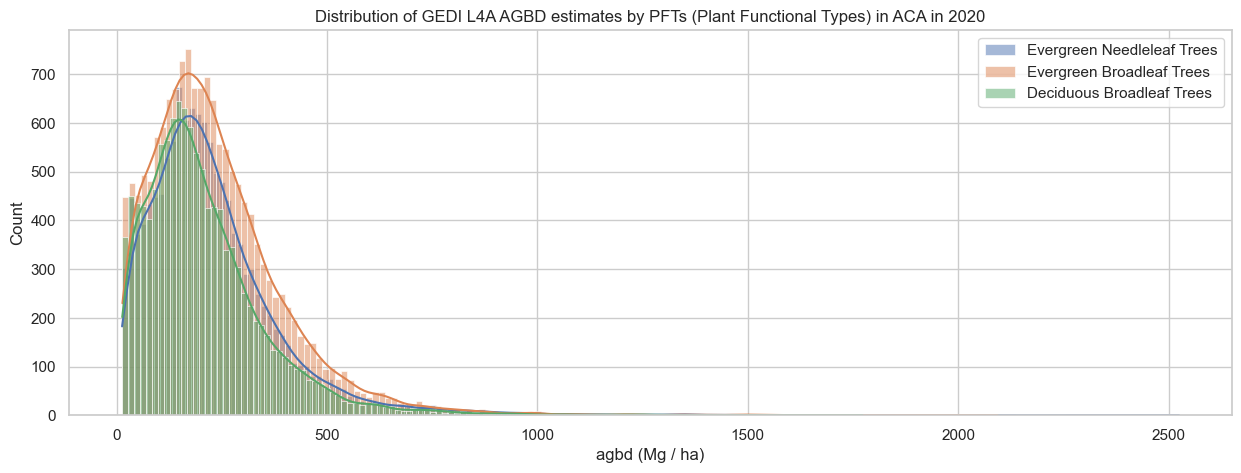

In [10]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 1: 'Evergreen Needleleaf Trees', 2: 'Evergreen Broadleaf Trees',
              3: 'Deciduous Needleleaf Trees',  4: 'Deciduous Broadleaf Trees', 5: 'Shrub', 6: 'Grass',
              7: 'Cereal Croplands', 8: 'Broadleaf Croplands', 9: 'Urban and Built-up Lands',
              10: 'Permanent Snow and Ice', 11: 'Barren', 255: 'Unclassified'}

# creating mask with good quality shots and trees/shrubs pft class
mask = (l4a_gdf['l4_quality_flag']==1) & (l4a_gdf['land_cover_data/pft_class'] <= 5 ) 
plt.figure(figsize=(15,5))
ax = l4a_gdf[mask].groupby('land_cover_data/pft_class')['agbd'].\
            apply(lambda x: sns.histplot(x, label = pft_legend[x.name], kde=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs (Plant Functional Types) in ACA in 2020')
plt.legend()
plt.show()

Let's also plot how the AGBD is distributed across elevation ranges for different PFTs.

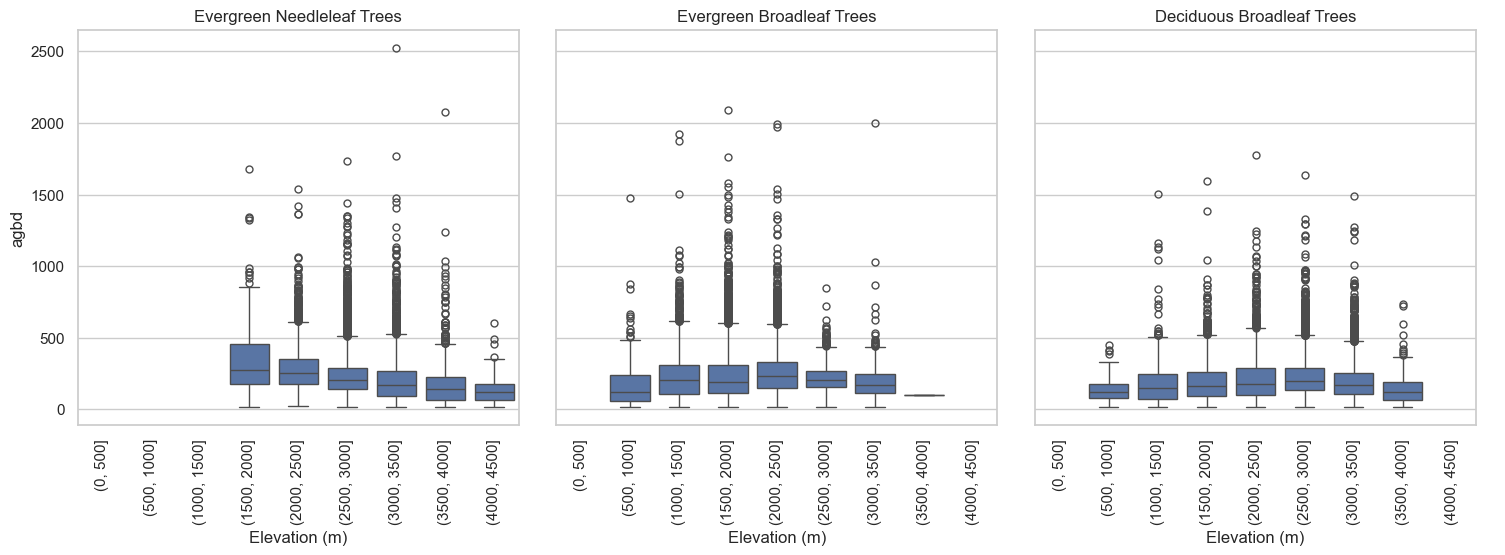

In [11]:
l4a_gdf['elev_bin']=pd.cut(l4a_gdf['elev_lowestmode'], bins =range(0, 5000, 500))
g = sns.catplot(x = "elev_bin", y = "agbd", data = l4a_gdf[mask], col="land_cover_data/pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)

Hyrax in its current form has some limitations. It does not support the subsetting of a string array, so GEDI L4A variables such as `predict_stratum` can not be accessed using the approach described above.

## References
```{bibliography}
:style: plain
:filter: docname in docnames
```